In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import os
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import librosa
from pathlib import Path
from collections import Counter
from scipy.signal import resample

from plotting_functions import *

In [16]:
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate) # d: amount of time btw smples
    Y = abs(np.fft.rfft(y)/n) # magnitude and normalize by length of signal
    
    return (Y, freq) # magnitude & freq

In [17]:
PATH = Path('./')
TRAIN_FILES = Path('./simple_data/')

In [18]:
train_df = pd.read_csv(PATH/'instruments.csv')
train_df.head()

,fname,label
0,5388d14d.wav,Saxophone
1,c685f05f.wav,Saxophone
2,36d20ab5.wav,Saxophone
3,d6665734.wav,Saxophone
4,7352e28f.wav,Saxophone


In [20]:
classes = train_df.label.unique().tolist()

In [21]:
train_df.set_index('fname', inplace=True)

# Rates

**NOTE**: `scipy.io.wavefile.read` automatically detects the rate unlike `librosa.load` where you have to specify it via `sr` argument. If `sr=None` the sample rate will be used. The default is `sr=22050` Hz.

In [22]:
file_path = TRAIN_FILES/train_df.index[0]
file_path

PosixPath('simple_data/5388d14d.wav')

In [23]:
def sample_rates(df):
    R = {}
    for f in df.index: 
        rate, signal = wavfile.read(TRAIN_FILES/f)
        if rate in R: R[rate] += 1
        else: R[rate] = 1
    return R
        
# sample_rates(train_df), len(train_df)

In [24]:
rate, signal = wavfile.read(TRAIN_FILES/train_df.index[0])
signal, rate

(array([-189, -245, -275, ...,    1,   -1,   -1], dtype=int16), 44100)

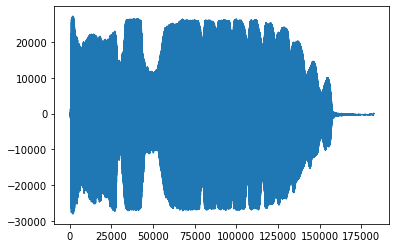

In [25]:
plt.plot(signal)
plt.show()

# Down-sample

In [26]:
def envelop_mask(y, rate, threshold=.0005):
    '''
    Computes the mask of valid/non-valid signals based on the envelop.
    
    to compute the evelop we don't want to check individual values that fall
    but when a consecutive values fall --> Rolling windows. 
    
    y: List[int], rate, threshold=.0005
    '''
    mask = []
    y = pd.Series(y).apply(np.abs)
    
    # if more periods are needed we get NaN in the extremess.
    y_mean = y.rolling(window=rate//10,center=True, min_periods=1).mean() 
    
    for mean in y_mean:
        if mean > threshold: mask.append(True)
        else: mask.append(False)
            
    return mask

In [27]:
# downsample/clean audio once
if len(os.listdir('./clean/'))==0:
    for f in tqdm_notebook(train_df.index):
        signal, rate = librosa.load(TRAIN_FILES/f, sr=16_000) # librosa does resampling on load st. aboids aliasing (indistinguishable signals).  44100 -> 16000
        mask = envelop_mask(signal, rate, threshold=0.005) # threshold to be 
        wavfile.write(filename='./clean/'+f, rate=rate, data=signal[mask])